In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import pickle as pkl
import matplotlib
matplotlib.rc('font', size=14)
plt.rc('axes', titlesize=24)
from omlt import OmltBlock, OffsetScaling
from omlt.io import load_keras_sequential
from omlt.neuralnet import FullSpaceSmoothNNFormulation
import pyomo.environ as pyo
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

2023-04-22 18:55:53.179836: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def true_optimize_he(T5):
    # first, create the Pyomo model
    m = pyo.ConcreteModel()
    
    m.Qc = pyo.Var(domain=pyo.NonNegativeReals, initialize = 0)
    m.FH = pyo.Var(domain=pyo.NonNegativeReals, initialize = 0)

    # Objective
    m.cost = pyo.Objective(expr = 0.01*m.Qc + 4*(m.FH - 1.7)**2, sense = pyo.minimize)

    # Constraints
    m.con1 = pyo.Constraint(expr = -10 - m.Qc + (T5 - 558)*m.FH + 0.5*m.Qc*m.FH >= 0)
    m.con2 = pyo.Constraint(expr = -10 - m.Qc + (T5 - 393)*m.FH >= 0)
    m.con3 = pyo.Constraint(expr = -250 - m.Qc + (T5 - 313)*m.FH >= 0)
    m.con4 = pyo.Constraint(expr = -250 - m.Qc + (T5 - 323)*m.FH <= 0)
    m.con5 = pyo.Constraint(expr = m.Qc >= 0)
    m.con6 = pyo.Constraint(expr = m.FH >= 0)

    solver = pyo.SolverFactory('baron', executable='~/BARON/baron').solve(m, tee=False)
    
#     if (solver.solver.status == SolverStatus.ok) and (solver.solver.termination_condition == TerminationCondition.optimal):
#         # Do nothing when the solution in optimal and feasible
#         print('optimal')
#     elif (solver.solver.termination_condition == TerminationCondition.infeasible):
#         print('infeasible')
#     else:
#         print('model did not solve correctly.')
#         print("Solver Status: ",  solver.solver.status)

    return pyo.value(m.Qc)

In [3]:
def io_optimize_he(T5):
    q =  np.array([[7989.44, -46.6823, 0.0896282, -5.66998e-5], [-7.05223, 1822.63, -6.28128, 0.00540818],
                   [-0.613943, -0.00776747, 4.08912e-5, -3.91282e-8], [3.14321, 677.343, -2.28002, 0.00191768]])
    p = np.array([[0.6821191553355692,-0.09298581174163523,0.00029942367449063635,-2.3877416262484956e-7],
                  [-0.030345502565197538,-14.7853275094872,0.05288867932952292,-4.728529880934358e-5]])       
    a = sum(p[0, j]*(T5)**(j) for j in range(4))
    b = sum(p[1, j]*(T5)**(j) for j in range(4))
    Q = np.empty(4)
    for i in range(4):
        Q[i] = sum(q[i, j]*(T5)**(j) for j in range(4))

    # first, create the Pyomo model
    m = pyo.ConcreteModel()
    m.Qc = pyo.Var(domain=pyo.NonNegativeReals, initialize = 0)
    m.FH = pyo.Var(domain=pyo.NonNegativeReals, initialize = 0)

    # Objective
    m.cost = pyo.Objective(expr = Q[0]*m.Qc**2 + Q[1]*m.Qc + Q[2]*m.FH**2 + Q[3]*m.FH, sense = pyo.minimize)

    # Constraints
    m.con1 = pyo.Constraint(expr = -10 - m.Qc + (T5 - 558)*m.FH + a*m.Qc + b*m.FH >= 0)
    m.con2 = pyo.Constraint(expr = -10 - m.Qc + (T5 - 393)*m.FH >= 0)
    m.con3 = pyo.Constraint(expr = -250 - m.Qc + (T5 - 313)*m.FH >= 0)
    m.con4 = pyo.Constraint(expr = -250 - m.Qc + (T5 - 323)*m.FH <= 0)
    m.con5 = pyo.Constraint(expr = m.Qc >= 0)
    m.con6 = pyo.Constraint(expr = m.FH >= 0)

    solver = pyo.SolverFactory('ipopt', executable='ipopt').solve(m, tee=False)
    
#     if (solver.solver.status == SolverStatus.ok) and (solver.solver.termination_condition == TerminationCondition.optimal):
#         # Do nothing when the solution in optimal and feasible
#     elif (solver.solver.termination_condition == TerminationCondition.infeasible):
#         print('infeasible')
#     else:
#         print('model did not solve correctly.')
#         print("Solver Status: ",  solver.solver.status)

    return pyo.value(m.Qc)

In [8]:
f = open('bilinear_nn_sigmoid_data_rescaled.pickle', 'rb')
bilinear_nn_data = pkl.load(f)
duty_data = np.transpose(bilinear_nn_data['duty']['local_reduced'])
duty_data = np.mean(duty_data, axis = 0)

In [9]:
f = open('test_data.pickle', 'rb')
full_nn_data = np.transpose(pkl.load(f))
full_nn_data = np.mean(full_nn_data, axis = 0)[:20]
full_nn_data

array([ 11.6396801 ,  14.24727726,  16.95154877,  19.72212372,
        22.52789726,  25.29708672,  27.99338646,  31.21954823,
        33.95237274,  37.13268013,  39.52984695,  41.59841309,
        53.79271812, 148.83406067, 163.05758209, 157.92568359,
       154.14533997, 151.82692566, 149.55254517, 148.13329926])

In [10]:
true_solution = np.empty(20)
io_solution = np.empty(20)
T5 = range(573, 593)
for i in range(len(T5)):
    true_solution[i] = true_optimize_he(T5[i])
    io_solution[i] = io_optimize_he(T5[i])

In [11]:
true_solution

array([ 12.02041047,  14.50130936,  17.04840079,  19.66728299,
        22.36439404,  25.1471943 ,  28.02440103,  31.00632937,
        34.10533616,  37.3363915 ,  40.7179677 ,  44.27329311,
        48.03226741, 167.96550698, 163.66563145, 158.98979483,
       153.81780457, 147.9473319 , 140.98386672, 131.90890215])

In [12]:
io_solution

array([ 12.0649521 ,  14.51449664,  17.04309434,  19.6553003 ,
        22.3560324 ,  25.15061715,  28.04485096,  31.04509135,
        34.1584176 ,  37.39298656,  40.75909327,  44.27399012,
        48.0141591 , 166.63099464, 162.30064395, 157.66220491,
       152.51810743, 146.57727273, 139.37432657, 130.09567512])

In [13]:
duty_data

array([12.09123945, 14.50047674, 16.98472825, 19.55072115, 22.20618244,
       24.96005299, 27.82277021, 30.80663964, 33.92633143, 37.19956816,
       40.64809199, 44.29906662, 48.18720023, 52.35808947, 56.87380325,
       61.82291405, 67.34034175, 73.65237817, 81.20288394, 91.17905873])

In [14]:
df = pd.DataFrame({'T5': T5,
                   'true': true_solution,
                   'io': io_solution,
                   'nn': duty_data})
df.to_csv('hx_data.csv', index=False)

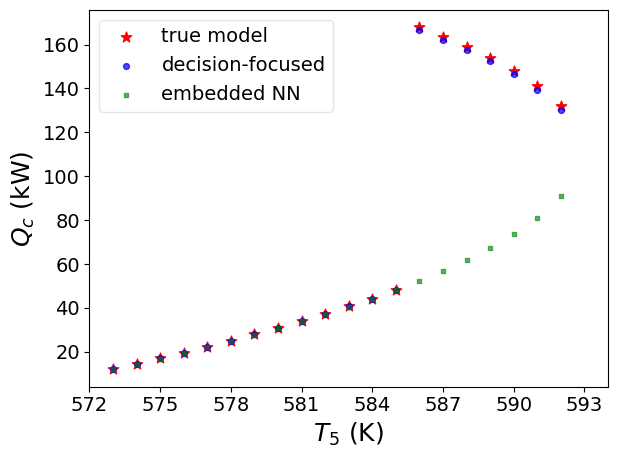

In [15]:
plt.figure()
plt.scatter(T5, true_solution, c = "red", marker = "*", s = 60, label = "true model", alpha = 1)
plt.scatter(T5, io_solution, c = "blue", marker = "o", s = 18, label = "decision-focused", alpha = 0.7)
plt.scatter(T5, duty_data, c = "green", marker = "s", s = 12, label = "embedded NN", alpha = 0.6)
# plt.scatter(T5, full_nn_data, c = "black", marker = "X", s = 36, label = "E2E-NN", alpha = 0.5)
plt.xlabel("$T_5$ (K)", fontsize = 18)
plt.ylabel("$Q_c$ (kW)", fontsize = 18)
plt.xticks(range(572,595,3))
# xticks(c(572:2:594), fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlim([572, 594])
plt.legend(loc = "best",  fancybox = True, framealpha = 0.5)
# display(gcf())
plt.tight_layout()
plt.savefig("final_comparison_sm_methods.pdf", transparent = True, bbox_inches = "tight")